In [2]:
from PIL import Image, ImageOps
import cv2
import json
import numpy as np

import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.optimize import leastsq   # 从scipy库的optimize模块引入leastsq函数

import random

img_path = '../OCR_data/output/'

In [3]:
def PIL_img_show(img):
    Image.fromarray(img).show()
    
def func1(x, p):
    A, T, theta, b, A2, theta2, A3, theta3 = p
    return A*np.sin(2*np.pi/T*x+theta)+b+A3*x

def func2(x, p):
    A, T, theta, b, A2, theta2, A3, theta3 = p
    return A*np.sin(2*np.pi/T*x+theta)+b+ A2*np.sin(2*2*np.pi/T*x+theta2)+ A3*x

def func3(x, p):
    A, T, theta, b, A2, theta2, A3, theta3 = p
    return A*np.sin(2*np.pi/T*x+theta)+b+ A2*np.sin(2*2*np.pi/T*x+theta2)+A3*np.sin(3*2*np.pi/T*x+theta3)

def residuals(p, y, x):
    """
    get residuals between the fitting curve and true data
    data: x,y
    parameters:p
    """
    return y - func1(x, p) 

def fit_curve_and_get_residuals(residuals, x, y, fitting_guess):
    [A, T, theta, b]=fitting_guess
    plsq = leastsq(residuals, [A, T, theta, b, A/10, theta, 1/100, theta], args=(y, x))
#     res = (residuals(plsq[0], y, x)**2).mean()
    
#     #return
#     return (res)/((y-plsq[0][3])**2).mean(), plsq, res

    res = np.abs(residuals(plsq[0], y, x)).mean()#res表示拟合误差
    res_norm = res/np.abs(plsq[0][0])
    #res_norm是为了将拟合误差归一化，因为不同的图片柱状图不一样高，为了res能放在一起比较
    #需要一个和柱状图高度无关的指标。本次的指标除以sin函数的高度，从实践来看效果还行，是否存在更鲁棒的设计？
    return res_norm, plsq, res

def get_column_hist_and_fitting(bin_img):
    
    img_height, img_width = bin_img.shape[:2]
    
    kernel_size = (int(img_height/500), int(img_width/100))#水平方向需要膨胀多一点使得水平的文字连接起来
    kernel = np.ones(kernel_size,np.uint8)
    erosion_img = cv2.erode(bin_img,kernel,iterations = 2)
#     PIL_img_show(erosion_img)

    row_sums=[]
    col_sums=[]
    for x in range(img_height):
        row_sums.append(img_width - sum(erosion_img[x, :])/255)#img_width for inversing pixel
    for y in range(img_width):
        col_sums.append(img_height -sum(erosion_img[:, y])/255)#img_height for inversing pixel
    
    x = np.array(range(len(col_sums)))
    y1 = np.array(col_sums)
    
    res_norm, plsq, res = fit_curve_and_get_residuals(residuals, x, y1, [1000, 700, 0, y1.mean()])
    
    [A, T, theta, b, A2, theta2, A3, theta3]=plsq[0]
    return res_norm, 1.5*T<img_width, plsq[0]    #1.5*T表示该拟合曲线的宽度很小，基本是普通二次函数的形式可以拟合的，没有波峰波谷，故排除

In [12]:
for img_id in range(42):
    img_name = 'img_'+str(1000000+img_id)+'.png'
    img = cv2.imread(img_path + img_name)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_height, img_width = gray_img.shape[:2]
    
    bin_threshold, bin_img = cv2.threshold(gray_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#     PIL_img_show(bin_img)

    res_norm, has_several_sin_wave, _ = get_column_hist_and_fitting(bin_img)
    
    print(img_id, res_norm, has_several_sin_wave)

0 1.057604595081524 True
1 0.6919006845580346 True
2 0.7675128453209358 True
3 0.5832395801880395 True
4 0.6489565670545923 True
5 0.7353865550629928 True
6 2.0732848292399577 True
7 3.2789871306375074 True
8 2.8056109541594587 True
9 2.2183861127421713 True
10 4.081017800506578 True
11 1.5086519966106047 True
12 4.347890643978011 True
13 2.9743633383411514 True
14 2.0663840630088237 True
15 1.772200993394924 True
16 1.6002264640017911 True
17 1.3376863810095267 True
18 1.2833256217481865 True
19 0.8762818685083481 True
20 0.9238526543608502 True
21 1.1606248120571951 True
22 0.6074916310889585 True
23 0.7500575118236932 True
24 0.8007360297821596 True
25 0.5935478199414859 True
26 0.17202942340528274 False
27 0.6973068408329572 True
28 1.1990281272981396 True
29 0.6620444900866327 True
30 2.3516744929784603 True
31 1.1422430981761693 True
32 0.8534385714459078 True
33 0.868617305156274 True
34 0.7847131965374056 True
35 1.135948323266806 True
36 1.3234547898319498 True
37 1.9980444161

In [8]:
img = cv2.imread(img_path + 'img_'+str(1000036)+'.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_heigth, img_width = gray_img.shape[:2]
print(img_heigth, img_width)


bin_threshold, bin_img = cv2.threshold(gray_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# PIL_img_show(bin_img)

kernel_size = (int(img_heigth/500), int(img_width/100))
kernel = np.ones(kernel_size,np.uint8)
erosion_img = cv2.erode(bin_img,kernel,iterations = 2)
PIL_img_show(erosion_img)

row_sums=[]
col_sums=[]
for x in range(img_heigth):
    row_sums.append(img_width - sum(erosion_img[x, :])/255)#img_width for inversing pixel
for y in range(img_width):
    col_sums.append(img_heigth -sum(erosion_img[:, y])/255)#img_height for inversing pixel

2338 1653


initial parameter: [472.3534787272911, 613.0545447036359, -1.646886481428629, 1046.475026649238]
fitting parameter [ 4.72353479e+02  6.13054545e+02 -1.64688648e+00  1.04647503e+03
  1.00000000e+02  0.00000000e+00 -2.48341971e-01  0.00000000e+00]


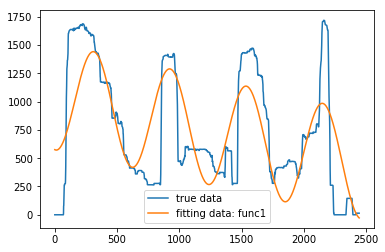

0.5935478199414859 -117.30519388814456 True


In [7]:
x = np.array(range(len(col_sums)))
y1 = np.array(col_sums)

# 调用leastsq进行数据拟合
# residuals为计算误差的函数
# p0为拟合参数的初始值
# args为需要拟合的实验数据
[A, T, theta, b]=[1000, 700, 0, y1.mean()]
res_norm, plsq, res = fit_curve_and_get_residuals(residuals, x, y1, [1000, 700, 0, y1.mean()])
[A, T, theta, b, A2, theta2, A3, theta3]=plsq[0]
print ("initial parameter:", [A, T, theta, b]) # 真实参数
print ("fitting parameter", plsq[0]) # 实验数据拟合后的参数


plt.plot(x, y1, label="true data")  # 带噪声的实验数据
#plt.plot(x, func2(x, plsq[0]), label="fitting data: func2")    # 拟合数据
plt.plot(x, func1(x, plsq[0]), label="fitting data: func1")    # 拟合数据
plt.legend()
plt.show()

print(res_norm, A3*A, 1.5*T<img_width)

In [87]:
print(plsq[0)

SyntaxError: invalid syntax (<ipython-input-87-805bebed4427>, line 1)

[ 1.04964127e+03  1.00006465e-02  1.01533267e+02  2.49698004e+03
 -5.72317549e+02  1.00085914e-02  1.02490188e+00]
[[ 3.15792042e+10  2.38462865e+02 -3.10795679e+06 -5.06809933e+04
   3.96265723e+09  4.20596818e+01 -5.51900174e+07]
 [ 2.38462865e+02  1.80327987e-06 -1.27108244e-02 -3.84712521e-04
   1.86206555e+01  1.59883986e-07 -4.17191803e-01]
 [-3.10795616e+06 -1.27108196e-02  4.52841414e+04  3.34684752e-01
  -4.76435796e+07 -6.63538751e-01  3.60261633e+03]
 [-5.06809934e+04 -3.84712521e-04  3.34685769e-01  1.81500162e+00
  -1.47004474e+03  7.29035716e-07  8.87626108e+01]
 [ 3.96265657e+09  1.86206505e+01 -4.76435796e+07 -1.47004367e+03
   5.01412526e+10  6.98034218e+02 -5.00382323e+06]
 [ 4.20596726e+01  1.59883916e-07 -6.63538751e-01  7.29050612e-07
   6.98034218e+02  9.72310300e-06 -4.66916252e-02]
 [-5.51900174e+07 -4.17191803e-01  3.60261743e+03  8.87626107e+01
  -5.00382439e+06 -4.66916414e-02  9.65282994e+04]]


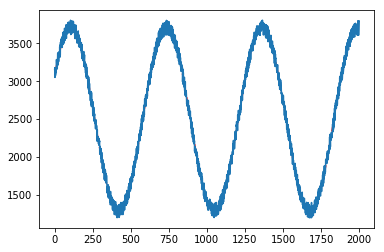

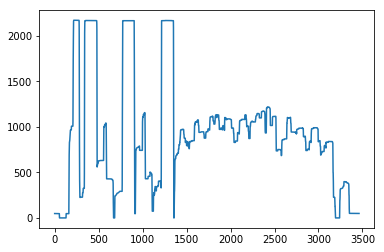

In [140]:
def f_fit(x,A, omega, theta, bias, A2, omega2, theta2):
    return A*np.sin(omega*x+theta)+bias+A2*np.cos(omega2*x+theta2)
def f_show(x,p_fit):
    A, omega, theta, bias, A2, omega2, theta2 = p_fit.tolist()
    return A*np.sin(omega*x+theta)+bias+A2*np.cos(omega2*x+theta2)

# x=np.array(range(len(col_sums)))
# y1 = np.array(col_sums)
# y1=1054*np.sin(x)+1999+[random.randint(400,600) for x in range(len(col_sums))]

x=np.array(range(2000))
y1=1054*np.sin(0.01*x)+1999+590*np.cos(0.01*x)+[random.randint(400,600) for x in range(2000)]

guess=(800, 0.012, 100, 2100, 600, 0.011, 0.1)
p_fit,pcov=curve_fit(f_fit,x,y1, guess)#曲线拟合
print(p_fit)#最优参数
print(pcov)#最优参数的协方差估计矩阵
y2=f_show(x,p_fit)

plt.plot(x,y2,'r--',label='fitting')
plt.plot(x, y1)
plt.show()


erosion_img = cv2.erode(bin_img,kernel,iterations = 2)
plt.plot(range(len(row_sums)), row_sums)
plt.show()

#get residuals
# residuals = ydata - func(xdata,p1,p2)
# fres = sum(residuals**2)

In [134]:
print(1./x.mean())
help(curve_fit)

0.0010005002501250625
Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...).  It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : An M-length sequence or an (k,M)-shaped array for functions with k predictors
        The independent variable where the data is measured.
    ydata : M-length sequence
        The dependent data --- nominally f(xdata, ...)
    p0 : None, scalar, or N-length sequence, optional
        Initial guess for the parameters.  If None, then the initial
        values will all be 1 (if the number of parameters for the funct

In [25]:

minLineLength = min(img_heigth, img_width)/10
maxLineGap = 10
lines = cv2.HoughLinesP(edges, 1, np.pi / 90, 100, minLineLength=minLineLength, maxLineGap=maxLineGap)

bin_threshold, bin_img_bak = cv2.threshold(gray_img,0,1,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#draw image with straight line(s) if lines is not None
if len(lines)!=0:
    print(len(lines))
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(bin_img_bak, (x1, y1), (x2, y2), (255, 255, 255), 1)
    PIL_img_show(bin_img_bak)

13


In [38]:
img_id = 2
img_name = 'img_'+str(1000000+img_id)+'.png'
img = cv2.imread(img_path + img_name)
print(img_id, get_straight_line_cnt(img, 1))

h
haha
2 0


In [44]:
def get_straight_line_cnt(img):
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_heigth, img_width = gray_img.shape[:2]
    #print(img_heigth, img_width)

    bin_threshold, bin_img = cv2.threshold(gray_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#    PIL_img_show(gray_img)
#     PIL_img_show(bin_img)

    edges = cv2.Canny(bin_img, 50, 150, apertureSize=3)
#     PIL_img_show(edges)
    minLineLength = min(img_heigth, img_width)/5
    maxLineGap = 10
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=minLineLength, maxLineGap=maxLineGap)
    
    try:
        lines_cnt = len(lines)
    except:
        lines_cnt = 0
    
    return lines_cnt

In [45]:
for img_id in range(42):
    img_name = 'img_'+str(1000000+img_id)+'.png'
    img = cv2.imread(img_path + img_name)
    print(img_id, get_straight_line_cnt(img))

0 0
1 0
2 0
3 0
4 0
5 0
6 1
7 0
8 0
9 0
10 0
11 0
12 0
13 0
14 0
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 4
24 0
25 2
26 20
27 8
28 6
29 6
30 40
31 19
32 11
33 16
34 14
35 16
36 30
37 20
38 213
39 8
40 20
41 7
